# Maksymilian Wojnar

# Zadanie 1 - Prosty ranking wierzchołków

In [1]:
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

np.random.seed(123)

## Grafy testowe

Funkcja pomocnicza do wybrania z grafu jego największej silnie spójnej składowej:

In [2]:
def get_max_connected(graph):
    components = list(nx.strongly_connected_components(graph))
    new_nodes = components[np.argmax([len(c) for c in components])]
    graph.remove_nodes_from(set(graph.nodes()) - new_nodes)
    return graph

Pierwszym testowanym grafem będzie graf losowy o 15 wierzchołkach.

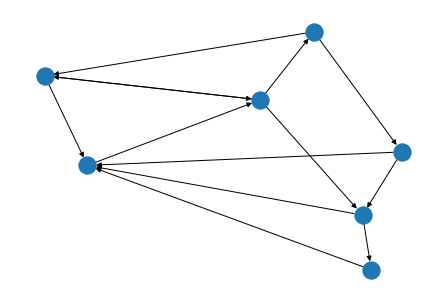

In [3]:
random_graph = get_max_connected(nx.fast_gnp_random_graph(15, 0.2, directed=True))
nx.draw(random_graph)

W poniższym grafie określiłem wejściowe oraz wyjściowe stopnie dla każdego wierzchołka. W ten sposób symuluję sieć, w której są dwie strony o dużej liczbie linków z innych witryn, dwie średnie strony oraz kilka małych. 

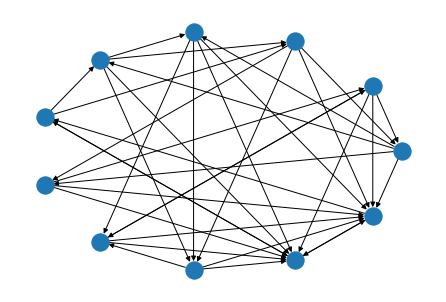

In [4]:
in_degrees = [2] * 7 + [3] * 2 + [8] * 2
out_degrees = [4] * 5 + [3] * 4 + [2] * 2
hh_graph = get_max_connected(nx.directed_havel_hakimi_graph(in_degrees, out_degrees))
nx.draw_circular(hh_graph)

Ciekawym przypadkiem jest graf - ścieżka, w którym wierzchołki (strony) posiadają pomiędzy sobą linki w dwóch kierunkach.

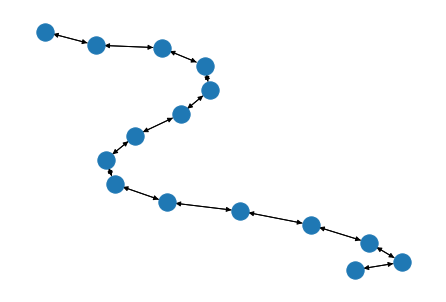

In [5]:
path_graph = get_max_connected(nx.path_graph(15).to_directed())
nx.draw(path_graph)

Ostatni przypadek testowy to graf pełny (linki w obudwu kierunkach) o 10 wierzchołkach.

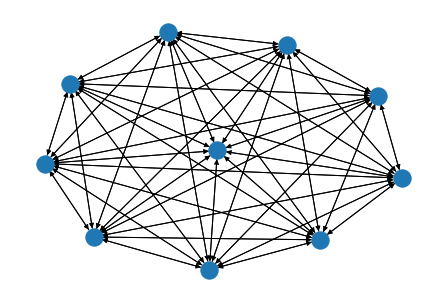

In [6]:
complete_graph = get_max_connected(nx.complete_graph(10).to_directed())
nx.draw(complete_graph)

## Implementacja prostego rankingu wierzchołków

In [7]:
def simple_page_rank(graph, max_iter=100, delta=0.0001):
    n = len(graph)
    # mapowanie wierzchołków na kolejne wiersze/kolumny macierzy
    nodes_map = {node: i for i, node in enumerate(graph.nodes())}
    # funkcja zwracająca wynik jako słownik { wierzchołek -> ranking }
    result = lambda x: {node: x[nodes_map[node]].item() for node in graph.nodes()}

    # program przechowuje macierz A jako macierz rzadką
    A = lil_matrix((n, n))
    N_u = [degree for _, degree in graph.out_degree(graph.nodes())]

    for edge in graph.edges():
        A[nodes_map[edge[1]], nodes_map[edge[0]]] = 1 / N_u[nodes_map[edge[0]]]

    A = csr_matrix(A)
    x_old = np.ones((n, 1))

    # metoda potęgowa wyszukiwania wektora własnego
    for _ in range(max_iter):
        x = normalize(A @ x_old, 'l2', axis=0)

        if np.linalg.norm(x_old - x) < delta:
            return result(normalize(x, 'l1', axis=0))

        x_old = x

    return result(normalize(x_old, 'l1', axis=0))

## Działanie prostego rankingu

Funkcje pomocnicze do rysowania grafów z naniesionymi wartościami rankingu dla każdego wierzchołka. Im wyższy ranking, tym większy wierzchołek oraz cieplejszy kolor.

In [8]:
def plot_page_rank(graph, method, ax, **kwargs):
    rank = method(graph, **kwargs)
    values = [rank.get(node, 0) * 10000 for node in graph.nodes()]
    nx.draw_circular(graph, node_size=values, node_color=values, cmap=plt.get_cmap('rainbow'), ax=ax)


def compare_results(graph, title='My PageRank', method=simple_page_rank, **kwargs):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    plot_page_rank(graph, method, ax[0], **kwargs)
    plot_page_rank(graph, nx.pagerank, ax[1])

    ax[0].set_title(title)
    ax[1].set_title('NetworkX PageRank')

    plt.tight_layout()
    plt.show()

W przypadku grafu losowego, moja implementacja daje zbliżone wyniki do implementacji bibliotecznej NetworkX. Można jednak zauważyć większy konrast pomiędzy wartościami dla poszczególnych wierzchołków - ważne wierzchołki mają jeszcze większy ranking, niż w implementacji bibilotecznej, a mniej ważniejsze, mają jeszcze mniejszy ranking.

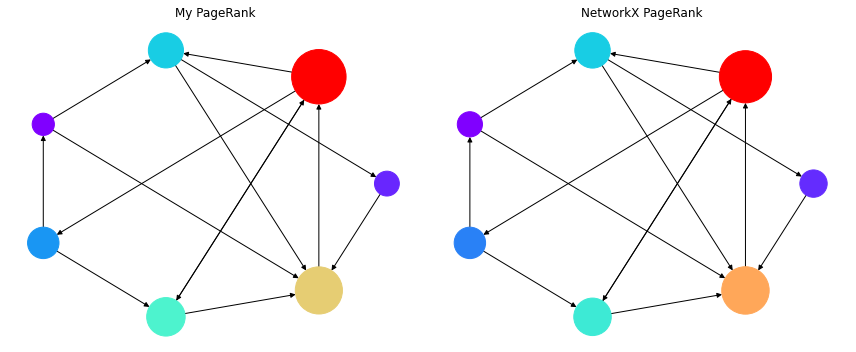

In [9]:
compare_results(random_graph)

Zgodnie z oczekiwaniem, dwie strony o dużej liczbie linków prowadzących do nich, zostały ocenione bardzo wysoko. Należy zwrócić również uwagę, że strona o małej liczbie linków,  do której linkują ważne strony, sama staje się ważna.

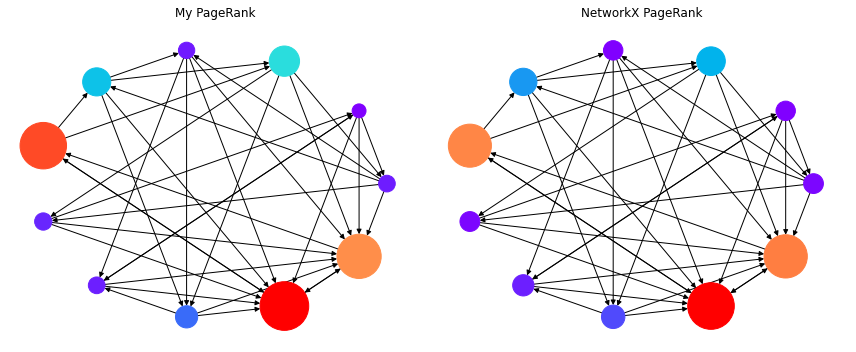

In [10]:
compare_results(hh_graph)

Dla ścieżki, moja implementacja zwróciła nieco inny wynik, niż implementacja biblioteczna. Niekoniecznie jest on błędny, wynika on z tego, że domyślnie NetworkX korzysta z "pełnej" wersji PageRank'a, a więc tej zakodowanej przeze mnie dopiero w zadaniu 2.

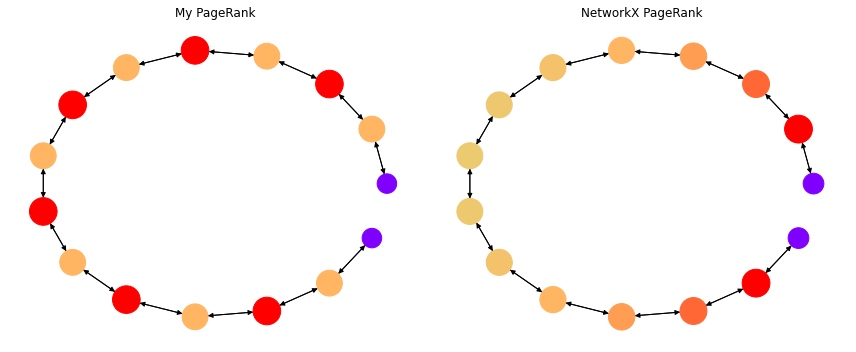

In [11]:
compare_results(path_graph)

W przypadku grafu pełnego, zgodnie z oczekiwaniami, wszystkie wierzchołki mają taki sam ranking.

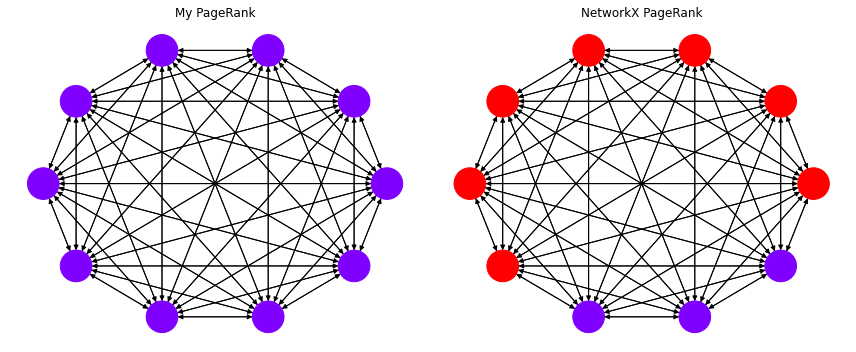

In [12]:
compare_results(complete_graph)

# Zadnie 2 - Page Rank

## Implementacja pełnego rankingu wierzchołków

In [13]:
def page_rank(graph, d=0.85, e=None, max_iter=200, delta=1e-6):
    n = len(graph)

    # utworzenie lub normalizacja wektora e
    if e is None:
        e = np.full((n, 1), 1 / n)
    else:
        e = normalize(e, 'l1', axis=0)

    # mapowanie wierzchołków na kolejne wiersze/kolumny macierzy
    nodes_map = {node: i for i, node in enumerate(graph.nodes())}
    # funkcja zwracająca wynik jako słownik { wierzchołek -> ranking }
    result = lambda x: {node: x[nodes_map[node]].item() for node in graph.nodes()}

    # program przechowuje macierz A jako macierz rzadką
    A = lil_matrix((n, n))
    N_u = [degree for _, degree in graph.out_degree(graph.nodes())]

    for edge in graph.edges():
        A[nodes_map[edge[1]], nodes_map[edge[0]]] = 1 / N_u[nodes_map[edge[0]]]

    A = csr_matrix(A)
    x_old = np.ones((n, 1))

    # wyszukiwanie wektora własnego w macierzy B = dA + (1 - d)e
    for _ in range(max_iter):
        x = d * A @ x_old + (1 - d) * n * np.sum(x_old, axis=0) * e
        x += e * (np.linalg.norm(x_old, 1) - np.linalg.norm(x, 1))

        if np.linalg.norm(x_old - x, 1) < delta:
            return result(normalize(x, 'l1', axis=0))

        x_old = x

    return result(normalize(x_old, 'l1', axis=0))

## Testy parametrów e oraz d

Na początek przedstawiam porównanie działania algorytmu dla różnych wartości parametru $d$ oraz tego samego wektora $e = \frac{1}{n}[1, 1, ..., 1]$. Widać wyraźnie, że im minejsza wartość $d$, tym bardziej znaczący w wyniku końcowym jest wektor $e$. Dla $d = 0$ wszystkie wierzchołki mają tę samą wagę. Wraz ze zwiększaniem się wartości parametru obserwujemy "wyostrzanie" różnic w wartości rankingu oraz wzrost kontrasrtu między najmniejszymi i największymi wartościami. Przy $d = 1$ otrzymujemy praktycznie te same wyniki, co dla prostego rankingu wierzchołków.

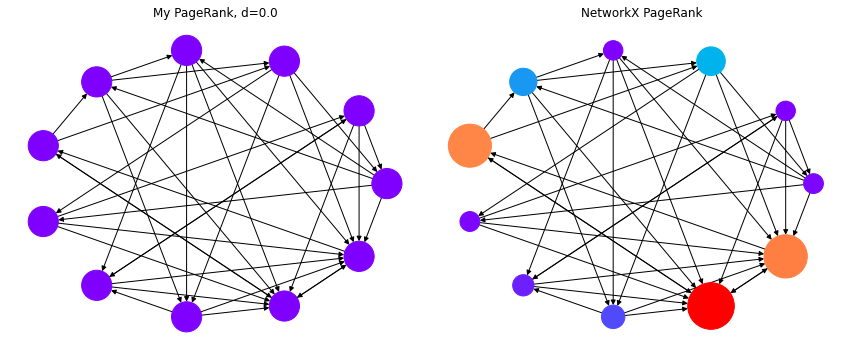

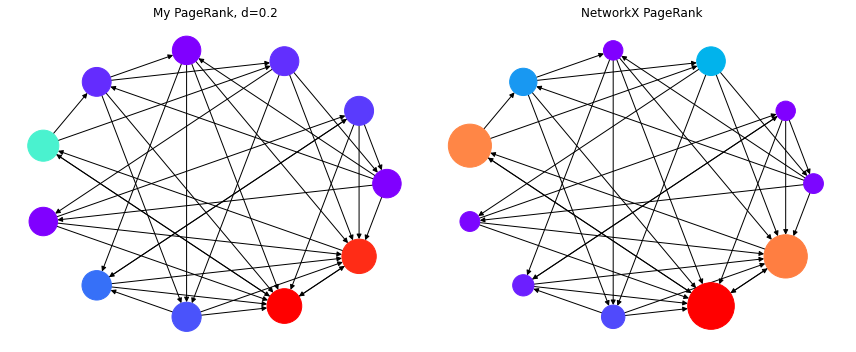

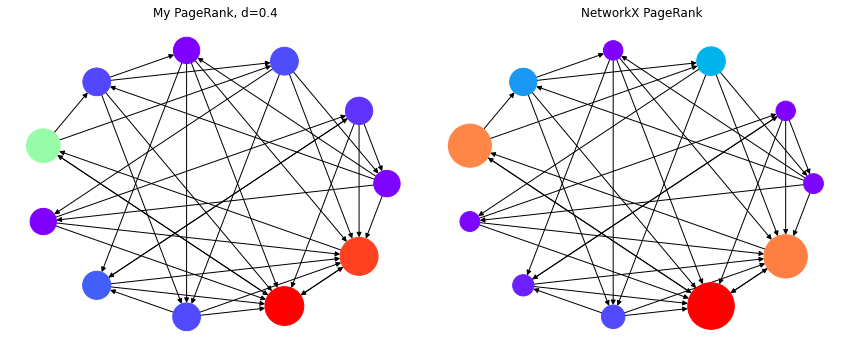

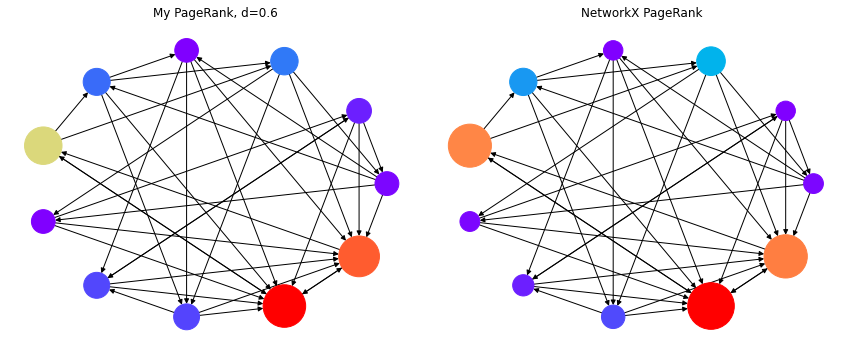

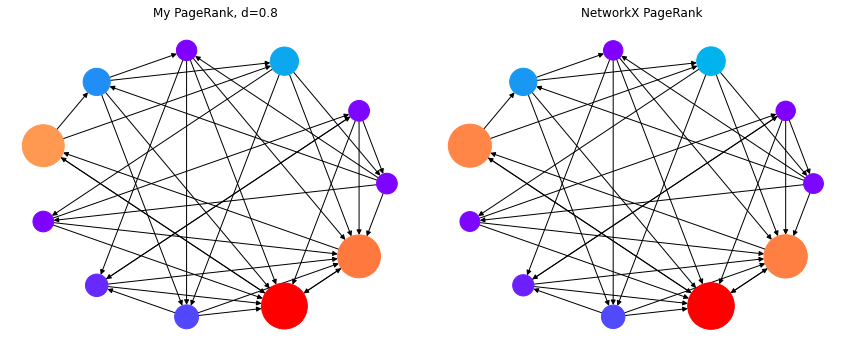

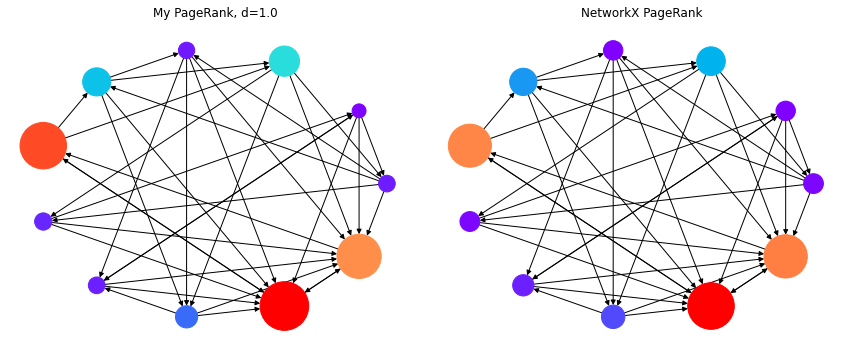

In [14]:
for d in np.linspace(0, 1, 6):
    compare_results(hh_graph, f'My PageRank, d={d:.1f}', page_rank, d=d)

Podobnie jest w przypadku ścieżki - dla $d = 0$ wszystkie wierzchołki są równe, a dla $d = 1$ otrzymujemy ten sam wynik, co wyżej. Wraz ze wzrostem parametru, widać łagodne przejście od równego traktowania wszystkich stron, do faworyzowania drugich "od końca" wierzchołków ścieżki.

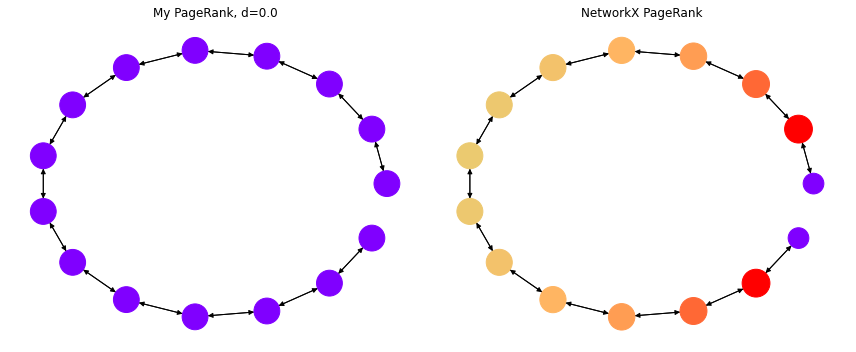

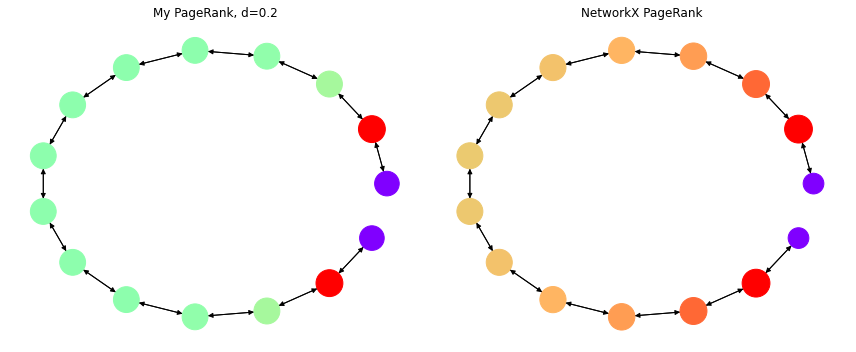

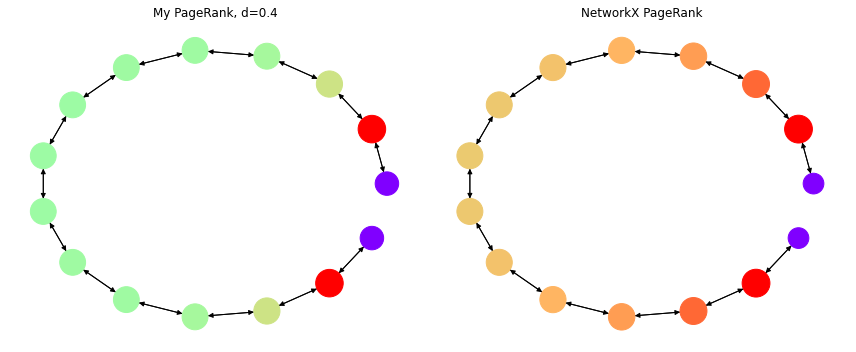

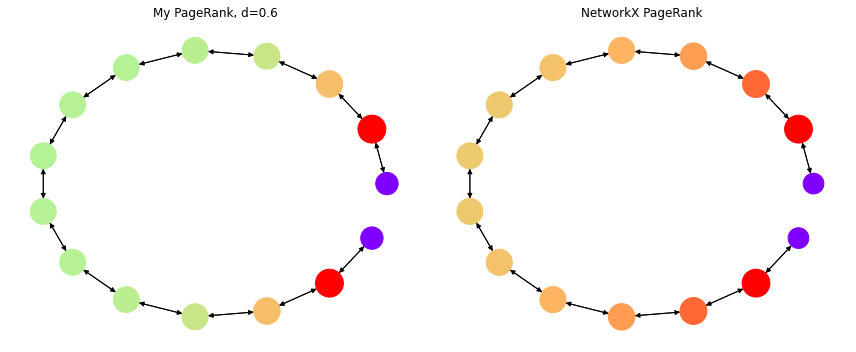

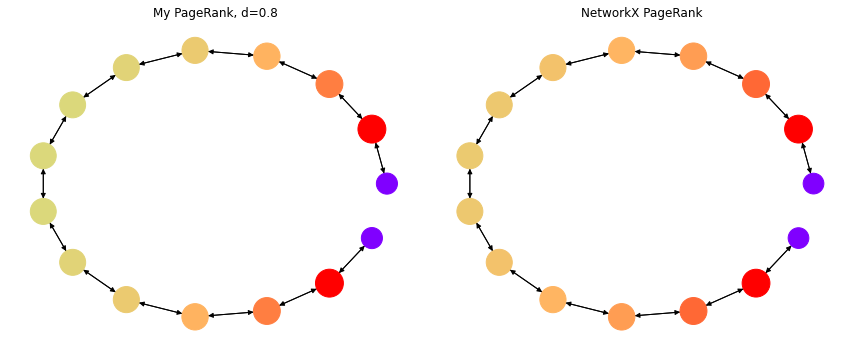

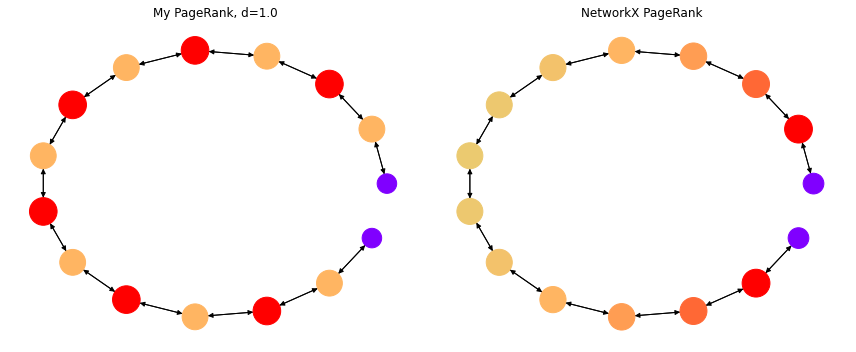

In [15]:
for d in np.linspace(0, 1, 6):
    compare_results(path_graph, f'My PageRank, d={d:.1f}', page_rank, d=d)

Teraz pokażę na przykładach działanie wektora $e$. Podobnie jak wyżej, będę zmieniał wartość parametru $d$ dla pewnego wybranego $e$. Na początek wezmę graf z ustalonymi licznościami krawędzi wchodzących i wychodzących. Ustalam wektor w taki sposób, aby faworyzować te strony, które były poprzednio średnio lub mniej znaczące. Widac wyraźnie, że dla małych wartości $d$ jest to skuteczna metoda zmiany preferencji rankingowych dla danej sieci. Im większa wartość parametru, tym ranking bliższy pierwotnej wartości.

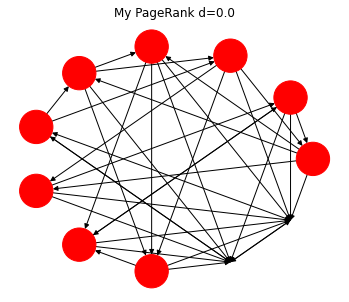

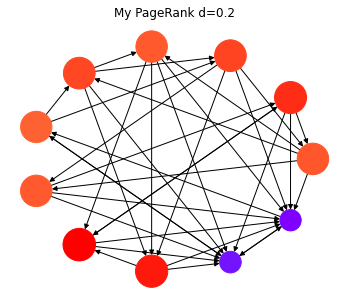

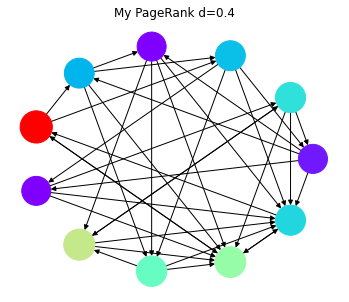

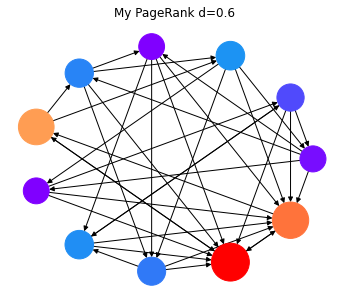

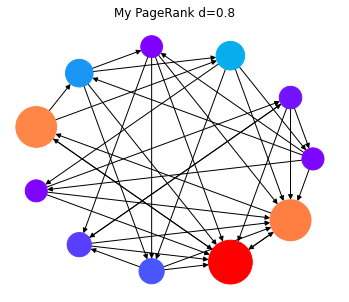

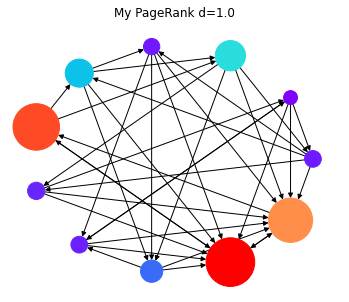

In [16]:
e = np.array([1] * 9 + [0] * 2).reshape((-1, 1))

for d in np.linspace(0, 1, 6):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    plot_page_rank(hh_graph, page_rank, ax, d=d, e=e)
    ax.set_title(f'My PageRank d={d:.1f}')

Podobnie wygląda to dla grafu - ścieżki. Tym razem ustliłem wektor w ten sposób, aby faworyzować jeden wierzchołek w środku ścieżki. Wraz ze zwiększaniem się parametru $d$, obserwujemy "rozmywanie" wartości rankingu na kolejne wierzchołki znajdujące się bliżej końców ścieżki.

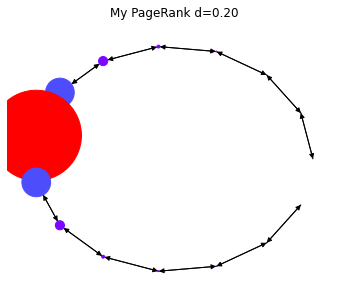

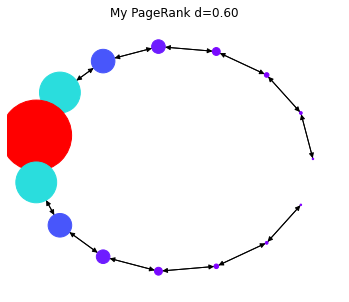

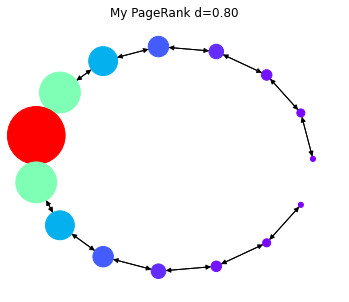

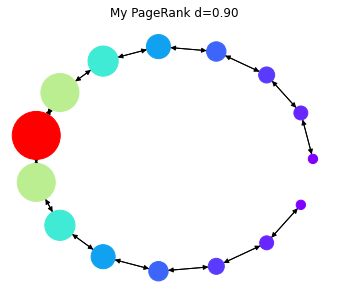

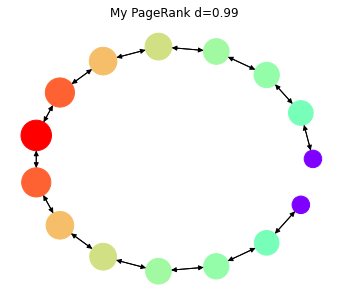

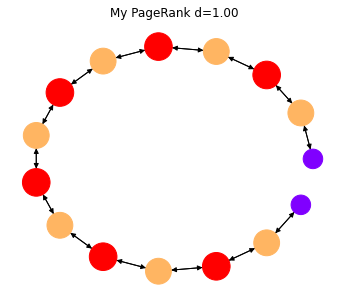

In [17]:
e = np.array([0] * 7 + [1] + [0] * 7).reshape((-1, 1))

for d in [0.2, 0.6, 0.8, 0.9, 0.99, 1]:
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    plot_page_rank(path_graph, page_rank, ax, d=d, e=e)
    ax.set_title(f'My PageRank d={d:.2f}')

## Testy grafów z bazy SNAP

Na początek przeprowadziłem porównanie rankingowania przez moją implementację oraz implementację biblioteczną algorytmu PageRank. Najmniejsza wartość, dla której wyniki się zgadzały, to różnica 3% (wartość względna); można zatem uznać, że obie implementacje dają bardzo podobne wyniki.

In [18]:
def test_snap_graphs(file_name):
    snap_graph = nx.read_edgelist(file_name, create_using=nx.DiGraph())
    snap_graph = get_max_connected(snap_graph)

    pr_res = page_rank(snap_graph)
    nx_res = nx.pagerank(snap_graph)

    assert np.allclose([pr_res[n] for n in snap_graph.nodes()], [nx_res[n] for n in snap_graph.nodes()], rtol=0.03)

Testowane grafy to "wiki-Vote" (7.115 wierzchołków, 103.689 krawędzi), "p2p-Gnutella04" (10.876 wierzchołków, 39.994 krawędzi), "p2p-Gnutella24" (26.518 wierzchołków, 65.369 krawędzi).

In [19]:
test_snap_graphs('Wiki-Vote.txt')
print('Passed')

test_snap_graphs('p2p-Gnutella04.txt')
print('Passed')

test_snap_graphs('p2p-Gnutella24.txt')
print('Passed')

Passed
Passed
Passed


Zamieszczam również histogramy wartości rankingów dla poszczególnych grafów.

In [20]:
def plot_snap_histogram(file_name, title='My PageRank', **kwargs):
    snap_graph = nx.read_edgelist(file_name, create_using=nx.DiGraph())
    snap_graph = get_max_connected(snap_graph)
    results = page_rank(snap_graph, **kwargs)
    
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.hist([results[node] for node in snap_graph.nodes()], bins=200)

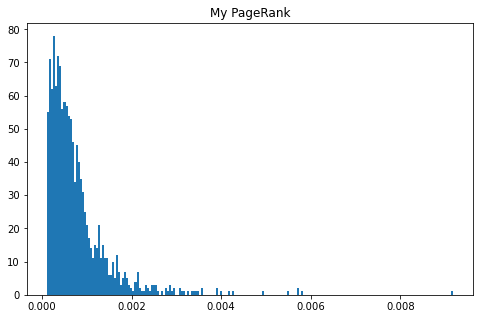

In [21]:
plot_snap_histogram('Wiki-Vote.txt')

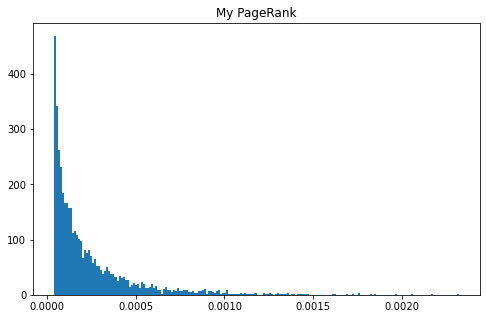

In [22]:
plot_snap_histogram('p2p-Gnutella04.txt')

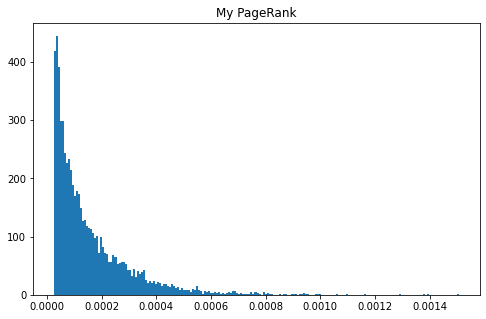

In [23]:
plot_snap_histogram('p2p-Gnutella24.txt')

Dla grafu "wiki-Vote" oraz "p2p-Gnutella04" przygotowałem również porównanie histogramów w zależności od wartości parametru $d$. Na wykresach możemy zauważyć, że przy wartości $d = 0$ rankingi wszystkich wierzchołków są zerowe. Dla niezerowej, ale małej wartości parametru, rankingi są rozłożone bardziej równomiernie, a wraz ze wzrostem parametru zaczynają się "wyostrzać" wierzchołki, które zyskują duże znaczenie i otrzymują rangi znacznie wyższe, niż pozostałe strony.

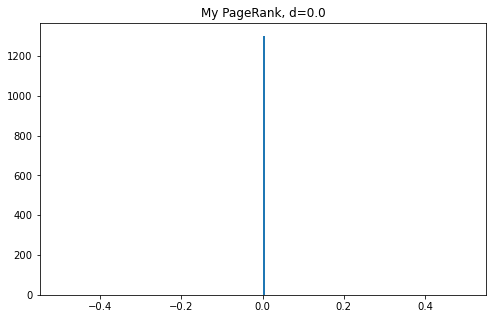

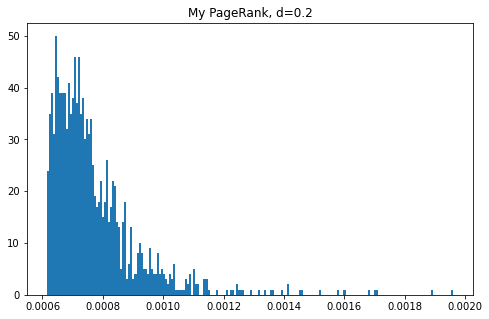

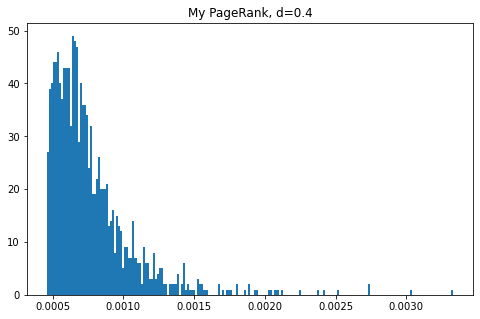

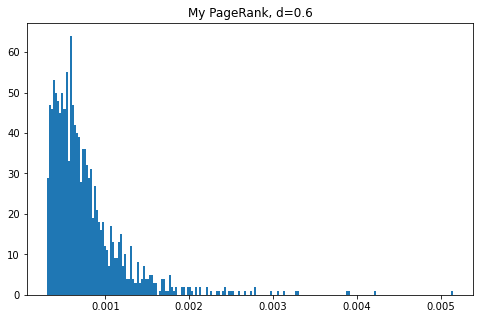

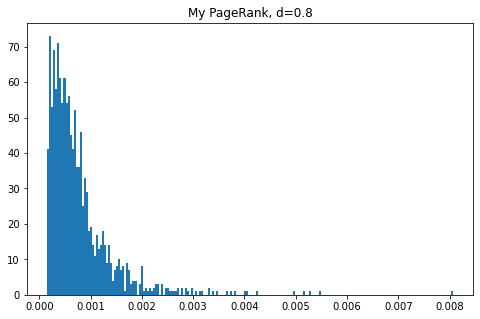

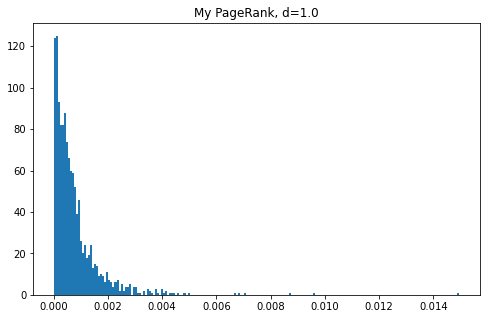

In [24]:
for d in np.linspace(0, 1, 6):
    plot_snap_histogram('Wiki-Vote.txt', f'My PageRank, d={d:.1f}', d=d)

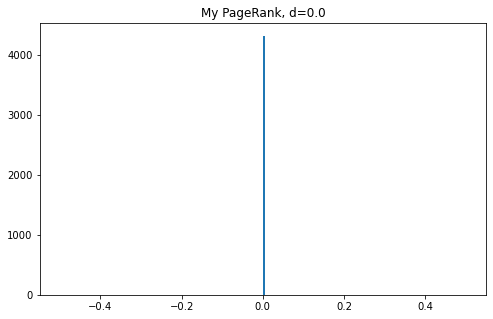

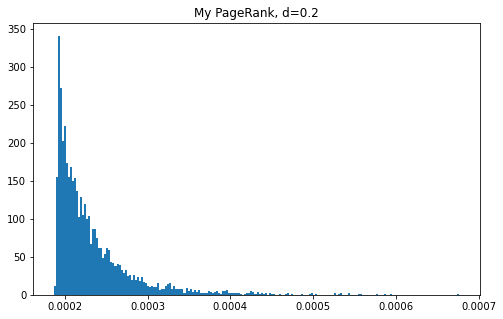

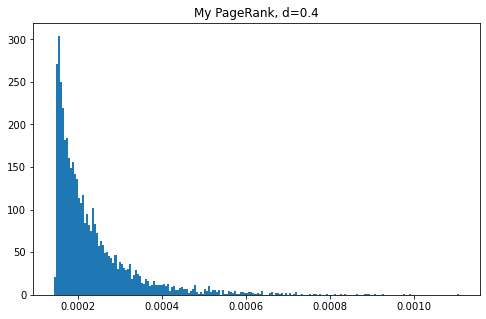

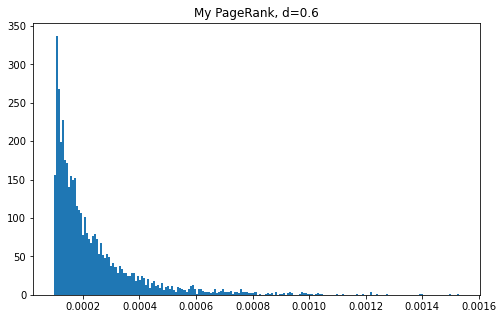

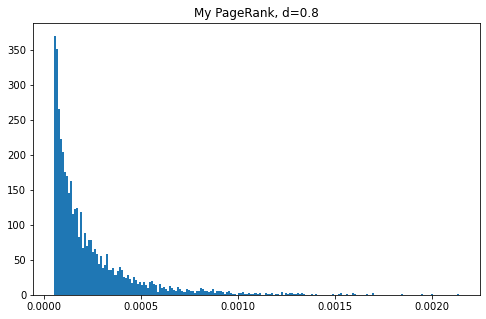

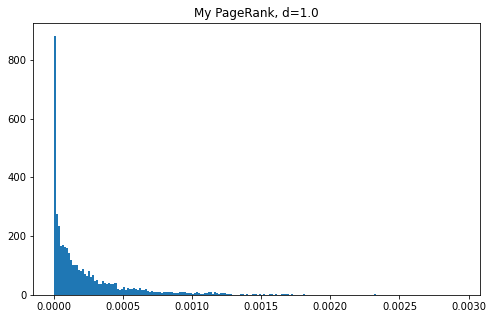

In [25]:
for d in np.linspace(0, 1, 6):
    plot_snap_histogram('p2p-Gnutella04.txt', f'My PageRank, d={d:.1f}', d=d)